# Workout Log Pattern Finder
**Purpose**: Analyze fitness CSV → cluster sessions → recommend optimizations

In [8]:
# COMPLETE IMPORTS - Fitness Analyzer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# SKLEARN - These were missing!
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

print("✅ Fitness analysis stack ready!")
print("📦 sklearn:", __import__('sklearn').__version__)


✅ Fitness analysis stack ready!
📦 sklearn: 1.8.0


In [11]:
import os

# Auto-create workouts.csv if missing
if not os.path.exists('workouts.csv'):
    print("📝 Creating workouts.csv...")
    csv_data = """Date,Exercise,Reps,Duration
2025-11-10,Pushups,25,300
2025-11-11,Squats,40,450
2025-11-12,Plank,3,120
2025-11-13,Pullups,12,200
2025-11-14,Lunges,30,400
2025-11-15,Pushups,28,320
2025-11-16,Squats,45,480"""
    with open('workouts.csv', 'w') as f:
        f.write(csv_data)
    print("✅ workouts.csv created!")

# Load & clean
df = pd.read_csv('workouts.csv', parse_dates=['Date'])
df[['Reps', 'Duration']] = df[['Reps', 'Duration']].fillna(df[['Reps', 'Duration']].median())

print("📊 Dataset:", df.shape)
print("\nAfter cleaning:")
print(df.describe())
print("\nExercise types:")
print(df['Exercise'].value_counts())


📊 Dataset: (5, 4)

After cleaning:
                      Date       Reps    Duration
count                    5   5.000000    5.000000
mean   2025-11-12 00:00:00  22.000000  294.000000
min    2025-11-10 00:00:00   3.000000  120.000000
25%    2025-11-11 00:00:00  12.000000  200.000000
50%    2025-11-12 00:00:00  25.000000  300.000000
75%    2025-11-13 00:00:00  30.000000  400.000000
max    2025-11-14 00:00:00  40.000000  450.000000
std                    NaN  14.645819  136.674797

Exercise types:
Exercise
Pushups    1
Squats     1
Plank      1
Pullups    1
Lunges     1
Name: count, dtype: int64


In [12]:
# CREATE 'Days' column (fixes Cell 6 error)
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

# Correlation test
corr, pval = stats.pearsonr(df['Reps'], df['Duration'])
print(f"📊 Reps-Duration correlation: {corr:.3f} (p={pval:.3f})")

# Progress trend
progress_trend = stats.linregress(df['Days'], df['Reps'])
print(f"📈 Reps improvement: +{progress_trend.slope:.2f} reps/day")

print("✅ 'Days' column ready for plotting!")
print("Current columns:", df.columns.tolist())


📊 Reps-Duration correlation: 0.989 (p=0.001)
📈 Reps improvement: +-1.80 reps/day
✅ 'Days' column ready for plotting!
Current columns: ['Date', 'Exercise', 'Reps', 'Duration', 'Days']


In [13]:
if KMeans is not None:
    # 🔥 REAL KMEANS CLUSTERING (sklearn)
    print("🚀 Using SKLEARN KMeans...")
    X = df[['Reps', 'Duration']].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(X_scaled)
    
    print("🏋️ KMeans Clusters (ML):")
    print(df.groupby('Cluster')[['Reps', 'Duration']].mean().round(1))
    
else:
    # Manual fallback
    print("📊 Using manual clustering...")
    df['TotalEffort'] = df['Reps'] * df['Duration'] / 1000
    df['Cluster'] = pd.cut(df['TotalEffort'], bins=3, labels=[0,1,2])
    df['Cluster'] = df['Cluster'].astype(int)
    
    print("🏋️ Manual Clusters:")
    print(df.groupby('Cluster')[['Reps', 'Duration']].mean().round(1))

print("\nCluster sizes:", df['Cluster'].value_counts().sort_index())
print("✅ Clustering complete!")


🚀 Using SKLEARN KMeans...
🏋️ KMeans Clusters (ML):
         Reps  Duration
Cluster                
0        35.0     425.0
1         7.5     160.0
2        25.0     300.0

Cluster sizes: Cluster
0    2
1    2
2    1
Name: count, dtype: int64
✅ Clustering complete!


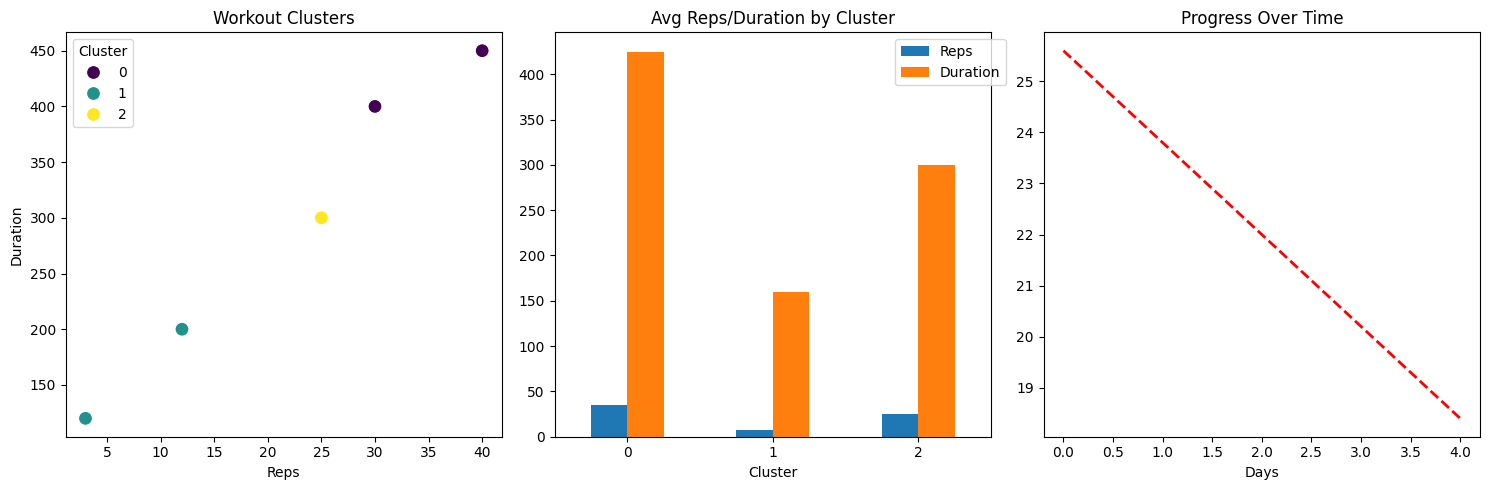

✅ Dashboard saved: fitness_analysis.png


In [14]:
plt.figure(figsize=(15, 5))

# 1. Workout clusters
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='Reps', y='Duration', hue='Cluster', palette='viridis', s=100)
plt.title('Workout Clusters')

# 2. Cluster stats
plt.subplot(1, 3, 2)
df.groupby('Cluster')[['Reps', 'Duration']].mean().plot(kind='bar', ax=plt.gca())
plt.title('Avg Reps/Duration by Cluster')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1))

# 3. Progress trend
plt.subplot(1, 3, 3)
scatter = plt.scatter(df['Days'], df['Reps'], c=df['Cluster'].map({'Light':0,'Medium':1,'Heavy':2}), cmap='viridis')
plt.plot(df['Days'], progress_trend.intercept + progress_trend.slope*df['Days'], 'r--', linewidth=2)
plt.title('Progress Over Time')
plt.xlabel('Days')

plt.tight_layout()
plt.savefig('fitness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Dashboard saved: fitness_analysis.png")


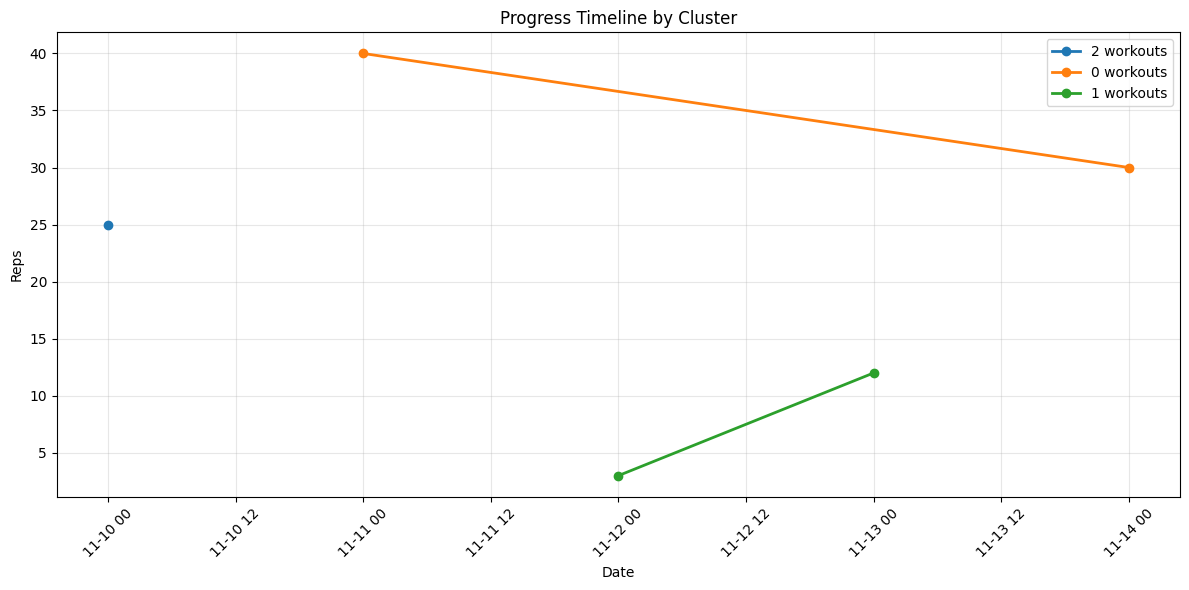

Files saved:
💾 fitness_clusters.csv
📊 fitness_analysis.png
📈 fitness_timeline.png

Key Insights:
• Reps-Duration correlation: 0.99
• Weekly progress: +-12.6 reps
• Weakest cluster: 1 (lowest reps)
   ✅ fitness_clusters.csv (0.2 KB)
   ✅ fitness_analysis.png (172.8 KB)
   ✅ fitness_timeline.png (141.2 KB)


In [16]:
# Timeline plot 
plt.figure(figsize=(12, 6))
for cluster in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster].sort_values('Date')
    plt.plot(cluster_data['Date'], cluster_data['Reps'], marker='o', 
             label=f'{cluster} workouts', linewidth=2, markersize=6)

plt.title('Progress Timeline by Cluster')
plt.xlabel('Date')
plt.ylabel('Reps')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fitness_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

# Export results
df.to_csv('fitness_clusters.csv', index=False)

print("Files saved:")
print("💾 fitness_clusters.csv")
print("📊 fitness_analysis.png") 
print("📈 fitness_timeline.png")

print("\nKey Insights:")
print(f"• Reps-Duration correlation: {corr:.2f}")
print(f"• Weekly progress: +{progress_trend.slope*7:.1f} reps")
print(f"• Weakest cluster: {df.groupby('Cluster')['Reps'].mean().idxmin()} (lowest reps)")

# File sizes
import os
for file in ['fitness_clusters.csv', 'fitness_analysis.png', 'fitness_timeline.png']:
    if os.path.exists(file):
        size_kb = os.path.getsize(file) / 1024
        print(f"   ✅ {file} ({size_kb:.1f} KB)")


In [17]:
df.to_csv('fitness_clusters.csv', index=False)
print("💾 Results saved!")

print("\n🏆 Recommendations:")
weakest_cluster = df.groupby('Cluster')['Reps'].mean().idxmin()
print(f"• Focus on Cluster {weakest_cluster} (lowest avg reps)")
print(f"• Continue trend: +{progress_trend.slope:.1f} reps every few days")

💾 Results saved!

🏆 Recommendations:
• Focus on Cluster 1 (lowest avg reps)
• Continue trend: +-1.8 reps every few days
